In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from scipy import stats
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
from collections import deque
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

Using TensorFlow backend.


In [3]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 27022
Timespan: 450 hours


18911
8103
Done


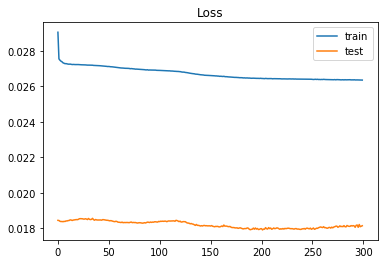

In [6]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_V5_{0}'.format(datetime.now()) + '.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [4]:
#Enter the values for you database connection
dsn_database = "ai_datasets_live" # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                 # e.g. 3306 
dsn_uid = "root"                # e.g. "user1"
dsn_pwd = ""                    # e.g. "Password123"


In [7]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

def get_last_trade():
    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
    cursor = conn.cursor()
    cursor.execute ("select * from trades order by date desc limit 1")
    return cursor.fetchone()

class StopLoss():
    
    def __init__(self, buy_price):
        self.balanced_price = buy_price + (buy_price * 0.01)
        self.threshold_price = self.balanced_price
        self.threshold_broken = False
    
    def check(self, new_price):
        if(new_price > self.balanced_price):
            self.threshold_broken = True
        else:
            self.threshold_broken = False
        
        if(self.threshold_broken == True):
            proposed_threshold = new_price - (new_price * 0.01)
            if (proposed_threshold > self.threshold_price):
                self.threshold_price = proposed_threshold
    
    def should_sell(self, next_price):
        if next_price <= self.threshold_price and self.threshold_broken == True:
            return True
        else:
            return False
    

In [11]:
diffs = deque([], maxlen=200)
lows = []
tops = []
last_trade = ()
top_lows = deque([], maxlen=30)
top_tops = deque([], maxlen=30)
bought = False
to_db = False
prev = 6739
in_cooldown = False
minute_ = 0
status = 0
current_decision = 0

while True:
    
    # Processing data
    minute_ = minute_ + 1
    btc = open('./philip_v1/1m/data-fetch/binance-data.csv','r')
    tw_sent = open('./philip_v1/1m/data-fetch/live_tweet.csv','r')
    rdt_sent = open('./philip_v1/1m/data-fetch/live_reddit.csv','r')
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    
    # Last price recieved
    real_price = bit_data[len(bit_data) - 1][0]
    
    # Scaling prices
    live = scaler.fit_transform(bit_data)
    
    # Creating datasets and making prediction
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    
    #Re scaling prices
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    
    # Save real price and prediction price
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    
    # Diference between real price and prediction
    alpha_diff = 100 * ((yhat_inverse[0][0] - float(real_price))/float(real_price))
    diffs.append(alpha_diff)
    diff_analisis = stats.describe(diffs)
    
    print "#######################################"
    print "In Cooldown ", in_cooldown
    print "#######################################"
    print "Minute: ", minute_
    print "#######################################"
    print "Diff analysis ", diff_analisis
    print "#######################################"
    print "########---> Initial values <---#######"
    print "#######################################"
    print "Pred: " + str(yhat_inverse[0][0])
    print "Real price: " + str(real_price)
    print "Diff: " + str(alpha_diff)

    if(len(diffs) >= 200):
        
        # Sorting all diffs
        sorted_diffs = sorted(diffs)
        # Taking the highest 75 (most negative)
        tops = sorted_diffs[0:75]
        # Taking the lowest 75 (most positive)
        lows = sorted_diffs[-75:]
        # Analyzing lists
        low_analisis = stats.describe(lows)
        top_analisis = stats.describe(tops)
        
        # Getting averages of tops and lows
        top_threshold = top_analisis.mean
        low_threshold = low_analisis.mean
        
        print "#######################################"
        print "######---> Averages (Phase 2) <---#####"
        print "#######################################"
        print "Average low: " + str(low_threshold)
        print "Average top: " + str(top_threshold)
        print "#######################################"
        print "#######################################"
        print "Top analysis", top_analisis
        print "#######################################"
        print "#######################################"
        print "Low analysis", low_analisis
        print "#######################################"
        print "#######################################"
        print "Low length", len(top_lows)
        print "Top length", len(top_tops)
        print "#######################################"
        print "#######################################"
        print "Low break: ", alpha_diff > low_threshold
        print "#######################################"
        print "Top break: ", alpha_diff < top_threshold 
        
        # If diff is greater than the average low
        if(alpha_diff > low_threshold):
            # Adding to top_lows list
            top_lows.append(alpha_diff)
            # Sorting
            sorted_lows = sorted(top_lows)
            top_lows = deque(sorted_lows, maxlen=30)
            
        # If diff is lower than the average high
        if(alpha_diff < top_threshold):
            # Adding to top_tops list
            top_tops.append(alpha_diff)            
            # Sorting 
            sorted_tops = sorted(top_tops)
            top_tops = deque(sorted_tops, maxlen=30)
             
        if(len(top_tops) >= 30 and len(top_lows) >= 30):
            # Analyzing top_tops and top_lows
            alpha_top_analisis = stats.describe(top_tops)
            alpha_low_analisis = stats.describe(top_lows)

            # Getting averages of top_tops and top_lows analisis
            alpha_top = alpha_top_analisis.mean
            alpha_low = alpha_low_analisis.mean

            print "####################################"
            print "####---> Signals (Phase 3) <---#####"
            print "Buy: " + str(alpha_top - alpha_top_analisis.variance)
            print "####################################"
            print "Sell: " + str(alpha_low)

            if(not in_cooldown):
                
                if bought:
                    status = ((real_price - buy_price) / buy_price) * 100
                    print "####################################"
                    print "Current status"
                    print "####################################"
                    print "Status", status
                    print "####################################"
                    
                    if('stop_loss' in locals() and isinstance(stop_loss, StopLoss)):
                        stop_loss.check(real_price)
                        print "Current status"
                        print "####################################"
                        print "Current stop_loss", stop_loss.threshold_price
                        print "####################################"
                    
                    if status >= 0.15:
                        alpha_low = 0.05
                    else:
                        alpha_low = alpha_low_analisis.mean
                        
                # If difference is lower that than the lowest top (negative value) -> BUY
                if alpha_diff < alpha_top  and not bought:
                    decision = 1
                    print "Buy at: " + str(real_price)
                    bought = True
                    to_db = True
                    in_cooldown = True

                elif 'stop_loss' in locals() and isinstance(stop_loss, StopLoss) and bought and stop_loss.should_sell(real_price):
                    decision = 2
                    print "Sell at: " + str(real_price)
                    bought = False
                    to_db = True
                    in_cooldown = True
                    buy_price = 0
                    del stop_loss
                # If difference is greater than the average low in the top_lows list -> SELL
                elif alpha_diff > alpha_low and bought:
                    decision = 2
                    print "Sell at: " + str(real_price)
                    bought = False
                    to_db = True
                    in_cooldown = True
                    buy_price = 0
                    del stop_loss
                    
                    # Saving decision to DB
                if to_db == True:
                    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
                    cursor=conn.cursor()
                    input_string = "INSERT INTO live_data (yhat, bit_data, sent_data, reddit_sent, date, decision) values ({},{},{},{},'{}',{});".format(
                        yhat_inverse[0][0],
                        bit_data[0][0],
                        tw_sent_data[4][0],
                        rdt_sent_data[4][0],
                        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
                        decision)
                    cursor.execute(input_string)
                    current_decision = cursor.lastrowid
                    conn.commit()
                    cursor.close()
                    to_db = False
            else:
                last_trade = get_last_trade()
                if last_trade and len(last_trade) is not 0 and current_decision == last_trade[3]:
                    in_cooldown = False
                    if(last_trade[2] == "Buy"):
                        buy_price = last_trade[1]
                        stop_loss = StopLoss(buy_price)
                        
                print "####################################"
                print "In Cooldown"
                print "####################################"
                print "Last trade", last_trade
                print "####################################"
                print "Current decision", current_decision
                print "####################################"
    time.sleep(60)

1
#######################################
In Cooldown  False
#######################################
Minute:  1
#######################################
Diff analysis  DescribeResult(nobs=1, minmax=(0.036194781914103136, 0.036194781914103136), mean=0.036194781914103136, variance=nan, skewness=0.0, kurtosis=-3.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 6731.44
Real price: 6729.0
Diff: 0.0361947819141


KeyboardInterrupt: 